# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The tasks include:

1. [Load input](#Assignment-1:-Load-Input-Data)
2. [Validate Input Data](#Assignment-2:-Validate-Input-Data)
3. [Construct Model](#Assignment-3:-Construct-Model)
4. [Calculate One Time Power Flow](#Assignment-4:-Calculate-One-Time-Power-Flow)
5. [Time Series Batch Calculation](#Assignment-5:-Time-Series-Batch-Calculation)
6. [N 1 Scenario-Batch-Calculation](#Assignment-6:-N-1-Scenario-Batch-Calculation)

The input data are CSV files in the `data/` folder:
* `node.csv`
* `line.csv`
* `source.csv`
* `sym_load.csv`


# Preparation

First import everything we need for this workshop:

In [1]:
import time
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    ComponentType,
    DatasetType,
    initialize_array
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

Let's define a timer class to easily benchmark the calculations:

In [2]:
class Timer:
    def __init__(self, name: str):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.perf_counter()

    def __exit__(self, *args):
        print(f'Execution time for {self.name} is {(time.perf_counter() - self.start):0.6f} s')

The following example measures the time for a simple add operation of two numpy arrays.

In [3]:
a = np.random.rand(1000000)
b = np.random.rand(1000000)
with Timer("Add Operation"):
    c = a + b

Execution time for Add Operation is 0.002952 s


# Assignment 1: Load Input Data

The following function loads the CSV data files from folder `../data/` and convert them into one dictionary of numpy structured arrays. The returned dictionary is a compatible input for the constructor of `PowerGridModel`. Please complete the function to construct the input data which is compatible with `PowerGridModel`.

In [4]:
def load_input_data() -> Dict[str, np.ndarray]:
    input_data = {}
    for component in [ComponentType.node, ComponentType.line, ComponentType.source, ComponentType.sym_load]:
        
        # Use pandas to read CSV data
        df = pd.read_csv(f'../data/{component.value}.csv')

        # Initialize array
        input_data[component] = initialize_array(DatasetType.input, component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data

# Load input data
with Timer("Loading Input Data"):
    input_data = load_input_data()


ComponentType.node: 2001
ComponentType.line: 2000
ComponentType.source:    1
ComponentType.sym_load: 2000
Execution time for Loading Input Data is 0.012547 s


# Assignment 2: Validate Input Data

It is recommended to validate your data before constructing the `PowerGridModel`. If you are confident about your input data, you can skip this step for performance reasons. The easiest way to validate your input data is using `assert_valid_input_data`, which will raise an exception if there are any errors in your data. Please have a look at the [Validation Examples](https://github.com/PowerGridModel/power-grid-model/blob/main/examples/Validation%20Examples.ipynb) for more detailed information on the validation functions.

In [5]:
# Validate input data
with Timer("Validating Input Data"):
    assert_valid_input_data(input_data=input_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Input Data is 0.009321 s


# Assignment 3: Construct Model

Create an instance of `PowerGridModel` using the input data. Benchmark the construction time.

In [6]:
# Construct model
with Timer("Model Construction"):
    model = PowerGridModel(input_data=input_data)

# Print the number of objects
print(model.all_component_count)

Execution time for Model Construction is 0.002634 s
{<ComponentType.node: 'node'>: 2001, <ComponentType.line: 'line'>: 2000, <ComponentType.source: 'source'>: 1, <ComponentType.sym_load: 'sym_load'>: 2000}


# Assignment 4: Calculate One-Time Power Flow

* Calculate one-time power flow, print the highest and lowest loading of the lines.
* Try with Newton-Raphson and linear method, compare the results and speed.

In [7]:
# Newton-Raphson Power Flow
with Timer("Newton-Raphson Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.newton_raphson)
    
# Print min and max line loading
print("Min line loading:", min(result[ComponentType.line]["loading"]))
print("Max line loading:", max(result[ComponentType.line]["loading"]))

Execution time for Newton-Raphson Power Flow is 0.003671 s
Min line loading: 0.1418844978380699
Max line loading: 1.6292378285645368


In [8]:
# Linear Power Flow
with Timer("Linear Power Flow"):
    result = model.calculate_power_flow(calculation_method=CalculationMethod.linear)
    
# Print min and max line loading
print("Min line loading:", min(result[ComponentType.line]["loading"]))
print("Max line loading:", max(result[ComponentType.line]["loading"]))

Execution time for Linear Power Flow is 0.002162 s
Min line loading: 0.1395686087394204
Max line loading: 1.6156849991055762


# Assignment 5: Time Series Batch Calculation

## Load Profile

Below we randomly generate a dataframe of load profile. 

* The column names are the IDs of `sym_load`
* Each row is one scenario
* Each entry specifies the active power of the load
* The reactive power is zero


In [9]:
# Generate random load profile oh hourly data
n_scenarios = 1000
n_loads = len(input_data[ComponentType.sym_load]) 
load_id = input_data[ComponentType.sym_load]["id"]
load_p = input_data[ComponentType.sym_load]["p_specified"]
profile = np.tile(load_p, (n_scenarios, 1)) + 5e5 * np.random.randn(n_scenarios, n_loads)
dti = dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="h")
df_load_profile = pd.DataFrame(profile, columns=load_id, index=dti)
display(df_load_profile)

,4002,4003,4004,4005,4006,4007,4008,4009,4010,4011,...,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001
2022-01-01 00:00:00,1.522690e+06,7.365325e+05,1.883955e+06,1.747342e+06,1.235460e+06,1.250241e+06,1.067713e+06,1.307628e+06,1.168910e+06,1.218901e+06,...,1.589131e+06,1.702425e+06,1.148132e+06,8.532146e+05,7.044042e+05,8.186826e+05,8.116150e+05,7.100930e+05,1.203160e+06,1.149239e+06
2022-01-01 01:00:00,8.881127e+05,1.053687e+06,3.734167e+05,1.614773e+06,1.348900e+06,3.942241e+05,9.418381e+05,-1.287045e+05,7.848680e+05,1.169359e+06,...,4.982993e+05,9.892282e+05,6.087048e+05,1.143115e+06,1.496269e+06,1.504554e+06,4.250855e+05,9.431208e+05,1.697681e+06,1.585010e+06
2022-01-01 02:00:00,9.811829e+05,1.413438e+06,9.972503e+05,1.233187e+06,1.295709e+06,3.746883e+05,1.720246e+06,1.248101e+06,4.639225e+05,9.123818e+05,...,1.866030e+06,1.744288e+06,1.412359e+06,7.322985e+05,8.552735e+05,9.632037e+05,1.006114e+06,6.947516e+05,7.969410e+05,1.487227e+06
2022-01-01 03:00:00,1.594312e+06,1.711561e+06,7.238942e+05,6.706983e+05,2.852392e+05,8.300269e+05,1.148656e+06,1.037572e+06,1.086457e+06,1.633151e+06,...,1.190132e+06,1.383107e+06,7.801834e+05,9.776243e+05,2.293418e+06,9.743710e+05,1.804552e+06,7.211640e+05,1.145045e+06,1.421976e+06
2022-01-01 04:00:00,4.667720e+05,1.128695e+06,1.028832e+06,5.444642e+05,1.052969e+05,5.439632e+05,1.916725e+06,1.075958e+06,9.885185e+05,1.375559e+06,...,5.633235e+05,5.196102e+05,4.177027e+05,1.353726e+06,7.087020e+05,7.139034e+05,8.842609e+05,7.882466e+05,-8.232680e+04,1.445546e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:00:00,6.554215e+05,1.519971e+06,7.346373e+05,2.468342e+05,1.391215e+06,2.756525e+05,1.064843e+06,1.632632e+06,2.255325e+06,3.975464e+05,...,3.516876e+05,9.236746e+05,1.067935e+06,1.237977e+06,4.839377e+05,1.140204e+06,1.391819e+06,1.668330e+06,6.788123e+05,1.408043e+06
2022-02-11 12:00:00,1.059431e+06,6.340614e+05,1.400879e+06,1.494647e+05,8.775668e+05,1.161970e+06,9.090381e+05,6.548579e+05,5.131747e+05,2.268062e+05,...,3.092005e+05,8.351009e+05,1.194604e+05,1.132886e+06,3.542770e+05,8.243507e+05,6.221985e+05,1.249335e+06,8.687152e+05,2.072785e+05
2022-02-11 13:00:00,6.521878e+05,2.955911e+05,3.741276e+05,4.800967e+05,4.995738e+05,1.584803e+06,-9.873880e+04,1.179757e+06,1.031841e+06,4.159367e+05,...,1.372591e+06,1.306696e+06,6.394788e+05,6.803029e+05,5.756530e+05,6.008684e+05,2.463446e+05,6.338162e+05,1.040108e+06,1.004782e+06
2022-02-11 14:00:00,9.818727e+05,1.401407e+06,6.278580e+05,1.540642e+06,7.379792e+05,9.621891e+05,1.303348e+06,1.306518e+06,6.933143e+05,1.436222e+06,...,1.673705e+06,2.049235e+06,6.810229e+05,7.839749e+05,1.888354e+06,5.954157e+05,5.539249e+05,1.735490e+06,1.495662e+06,9.269474e+05


## Run Time Series Calculation

We want to run a time-series load flow batch calculation using the dataframe.

* Convert the load profile into the compatible batch update dataset.
* Run the batch calculation.
* Compare the calculation methods `newton_raphson` and `linear`.

In [10]:
# Initialize an empty load profile
load_profile = initialize_array(DatasetType.update, ComponentType.sym_load, df_load_profile.shape)

# Set the attributes for the batch calculation (assume q_specified = 0.0)
load_profile["id"] = df_load_profile.columns.to_numpy()
load_profile["p_specified"] = df_load_profile.to_numpy()
load_profile["q_specified"] = 0.0

# Construct the update data
update_data = {ComponentType.sym_load: load_profile}

In [11]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 2.216290 s


In [12]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    output_data = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 1.261293 s


In [13]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    output_data_linear = model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 0.610796 s


## Plotting batch results

Lets say we wish to plot the loading of the `line with id 2007` vs time. We can use matplotlib to do so. (Note: The grid and results are randomly generated so dont be alarmed to see loading >100% or other unrealistic result)  

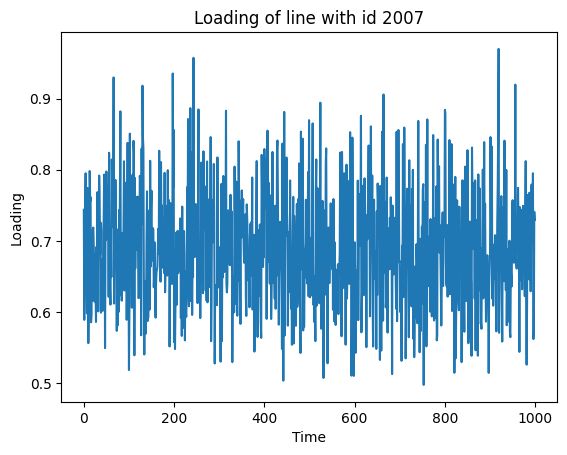

In [14]:
# Plot the loading of line with id 2007 vs time.
line_2007_idx = np.where(output_data[ComponentType.line]["id"] == 2007)
result_loading = output_data[ComponentType.line]["loading"][line_2007_idx]
plt.plot(result_loading)
plt.title('Loading of line with id 2007')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()

## Indexing the results

Find the time stamps where loading in `line with id 2007` is greater than `90%`

In [15]:
# Times when loading of line with id 2007 when its greater than 90%
ind = np.where(result_loading > 0.9)
df_load_profile.index[ind]

DatetimeIndex(['2022-01-03 18:00:00', '2022-01-06 10:00:00',
               '2022-01-09 05:00:00', '2022-01-11 03:00:00',
               '2022-01-28 16:00:00', '2022-02-08 07:00:00',
               '2022-02-09 20:00:00'],
              dtype='datetime64[ns]', freq=None)

# Assignment 6: N-1 Scenario Batch Calculation

We want to run a N-1 Scenario analysis. For each batch calculation, one `line` is disconnected at from- and to-side.

In [16]:
n_lines = len(input_data[ComponentType.line])

# Initialize an empty line profile
line_profile = initialize_array(DatasetType.update, ComponentType.line, (n_lines, n_lines))

# Set the attributes for the batch calculation
line_profile["id"] =  input_data[ComponentType.line]["id"]
line_profile["from_status"] = 1 - np.eye(n_lines, dtype=np.uint8)
line_profile["to_status"] = 1 - np.eye(n_lines, dtype=np.uint8)

# Construct the update data
update_data = {ComponentType.line: line_profile}

In [17]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
with Timer("Validating Batch Data"):
    assert_valid_batch_data(input_data=input_data, update_data=update_data, calculation_type=CalculationType.power_flow)

Execution time for Validating Batch Data is 3.770749 s


In [18]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.newton_raphson)

Execution time for Batch Calculation using Newton-Raphson is 4.393309 s


In [19]:
# Run linear power flow
with Timer("Batch Calculation using linear calculation"):
    model.calculate_power_flow(update_data=update_data, calculation_method=CalculationMethod.linear)

Execution time for Batch Calculation using linear calculation is 2.711576 s


## Parallel processing
The `calculate_power_flow` method has an optional `threading` argument to define the number of threads ran in parallel. Experiment with different threading values and compare the results...

In [20]:
# By default, sequential threading is used
with Timer("Sequential"):
    model.calculate_power_flow(update_data=update_data)

# Single thread, this is essentially the same as running a single thread
with Timer("Single thread"):
    model.calculate_power_flow(update_data=update_data, threading=1)

# Two threads should be faster    
with Timer("Two threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=2)

# Four threads should be even faster    
with Timer("Four threads in parallel"):
    model.calculate_power_flow(update_data=update_data, threading=4)

# Use number of threads based the machine hardware    
with Timer("Use number of threads based the machine hardware"):
    model.calculate_power_flow(update_data=update_data, threading=0)

Execution time for Sequential is 4.250867 s
Execution time for Single thread is 4.385878 s
Execution time for Two threads in parallel is 2.271115 s
Execution time for Four threads in parallel is 1.146302 s
Execution time for Use number of threads based the machine hardware is 0.559351 s
